<a href="https://colab.research.google.com/github/gauravreddy08/deep-learning-tensorflow/blob/main/notebooks/04_transfer-learning-feature-extraction-tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer Learning** : Feature Extraction

**Transfer Learning** in leveraging on a existing models's architecture and learned patterns, which are proven to work on similar problem of ours.

## **Becoming One with the data**

[**Kaggle's Food101**](https://www.kaggle.com/dansbecker/food-101) dataset has over 100 food classes but for now we would be only importing 10% of 10 classes from orginal Dataset.

In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-05-20 05:47:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.250.101.128, 2607:f8b0:4023:c0b::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   149MB/s    in 1.1s    

2021-05-20 05:47:43 (149 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath} ")

There are 2 directories and 0 images in 10_food_classes_10_percent 
There are 10 directories and 0 images in 10_food_classes_10_percent/train 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen 
There are

Instead of using 750 images in a class we are now using only 75 images. This is to touch on the Power of transfer learning.

## **Preprocessing the Data**

In [ ]:
import tensorflow as tf

### **Creating Data Generators and rescaling the images**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print("Training Images : ")
train_data = train_datagen.flow_from_directory(train_dir,
                                                target_size=IMG_SIZE,
                                                batch_size=BATCH_SIZE)
print("")

print("Test Images : ")
test_data = test_datagen.flow_from_directory(test_dir,
                                              target_size=IMG_SIZE,
                                              batch_size=BATCH_SIZE)

Training Images : 
Found 750 images belonging to 10 classes.

Test Images : 
Found 2500 images belonging to 10 classes.


## **Setting up the Callbacks**

**Callbacks** are the extra funtionality you can add to your models to be performed during or after training.

* Tracking experiments with **TensorBoard Callback**
* Model checkpoint with **ModelCheckpoint Callback**
* Stopping a model from training longer with **EarlyStopping Callback**

In [ ]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_call = tf.keras.callbacks.TensorBoard(log_dir)
  print(f"Saving TensorBoard log files to {log_dir}")
  return tensorboard_call

## **Importing Models from Tensorflow Hub**

In the past we've created our own Neural Network models layer by layer from scratch.

But now, we're goint to do a similar process but the majority of our model's layers are going to come from **TensorFlow Hub**.

**Feature extraction transfer learning** is when you take the underlying patterns (also called weights) a pretrained model has learned and adjust its outputs to be more suited to your problem. 


**EfficientNet Model :** https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

**ResNet Model :** https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5

### **ResNet Model**

In [ ]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
def create_model(model_url, num_classes=10):
  '''
  Takes TFH url and creates keras Sequential model with it.

  Args:
    model_url : A Tensorfloe Hub feature extraction URL.
    num_classes : Number of output Neurons in output layer
  '''

  # Downloading pretrained model and saving it as a Sequential Layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, #Freeze already learned patterns
                                           name="feature_ectraction_layer",
                                           input_shape=(IMG_SIZE + (3, ))) 
  model = tf.keras.Sequential([
            feature_extractor_layer,
            layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])
  return model

In [ ]:
resnet_model = create_model(resnet_url, 10)

resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_ectraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compiling ResNet Model

resnet_model.compile(loss=tf.keras.losses.categorical_crossentropy,
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
# Training the model

res_history = resnet_model.fit(train_data,
                               epochs=5,
                               steps_per_epoch=len(train_data),
                               validation_data=test_data,
                               validation_steps=len(test_data),
                               callbacks=[create_tensorboard_callback('tensorflow_hub',
                                                                      'resnet50v2')])

Saving TensorBoard log files to tensorflow_hub/resnet50v2/20210520-054756
Epoch 1/5
24/24 [==============================] - 54s 786ms/step - loss: 2.3726 - accuracy: 0.2087 - val_loss: 1.1967 - val_accuracy: 0.6284
Epoch 2/5
24/24 [==============================] - 15s 655ms/step - loss: 0.9327 - accuracy: 0.7264 - val_loss: 0.8626 - val_accuracy: 0.7328
Epoch 3/5
24/24 [==============================] - 15s 655ms/step - loss: 0.6220 - accuracy: 0.8254 - val_loss: 0.7668 - val_accuracy: 0.7568
Epoch 4/5
24/24 [==============================] - 15s 646ms/step - loss: 0.4987 - accuracy: 0.8672 - val_loss: 0.7092 - val_accuracy: 0.7752
Epoch 5/5
24/24 [==============================] - 15s 651ms/step - loss: 0.3886 - accuracy: 0.8984 - val_loss: 0.6909 - val_accuracy: 0.7748


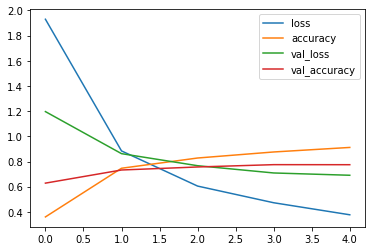

In [ ]:
pd.DataFrame(res_history.history).plot()

### **EfficientNet B0 Model**

In [ ]:
efficientnet_model = create_model(efficientnet_url, 10)

efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_ectraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
# Compiling EfficientNet Model

efficientnet_model.compile(loss=tf.keras.losses.categorical_crossentropy,
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

In [ ]:
# Training the model

eff_history = efficientnet_model.fit(train_data,
                                     epochs=5,
                                     steps_per_epoch=len(train_data),
                                     validation_data=test_data,
                                     validation_steps=len(test_data),
                                     callbacks=[create_tensorboard_callback('tensorflow_hub',
                                                                            'efficientnetb0')])

Saving TensorBoard log files to tensorflow_hub/efficientnetb0/20210520-055001
Epoch 1/5
24/24 [==============================] - 25s 777ms/step - loss: 2.0620 - accuracy: 0.2996 - val_loss: 1.2497 - val_accuracy: 0.7596
Epoch 2/5
24/24 [==============================] - 14s 622ms/step - loss: 1.1179 - accuracy: 0.7729 - val_loss: 0.8385 - val_accuracy: 0.8304
Epoch 3/5
24/24 [==============================] - 14s 622ms/step - loss: 0.7704 - accuracy: 0.8393 - val_loss: 0.6767 - val_accuracy: 0.8488
Epoch 4/5
24/24 [==============================] - 15s 625ms/step - loss: 0.6179 - accuracy: 0.8452 - val_loss: 0.5972 - val_accuracy: 0.8600
Epoch 5/5
24/24 [==============================] - 15s 626ms/step - loss: 0.5305 - accuracy: 0.8682 - val_loss: 0.5440 - val_accuracy: 0.8668


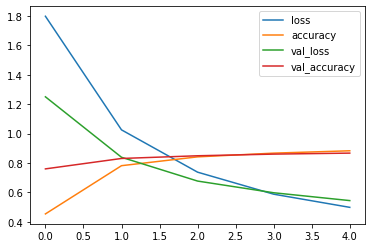

In [ ]:
pd.DataFrame(eff_history.history).plot()

## **Comparing our Models using TensorBoard**

In [ ]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

2021-05-20 05:51:27.211547: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2

In [ ]:
!tensorboard dev list

2021-05-20 05:51:56.150409: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/gHJ3MbKGQVOPPDldY0pd3g/
	Name                 [No Name]
	Description          [No Description]
	Id                   gHJ3MbKGQVOPPDldY0pd3g
	Created              2021-05-20 05:51:52 (25 seconds ago)
	Updated              2021-05-20 05:51:54 (23 seconds ago)
	Runs                 4
	Tags                 3
	Scalars              40
	Tensor bytes         0
	Binary object bytes  5891438
https://tensorboard.dev/experiment/WQfmqQJzRief7IXxzO3zRQ/
	Name                 [No Name]
	Description          [No Description]
	Id                   WQfmqQJzRief7IXxzO3zRQ
	Created              2021-05-20 03:34:37 (2 hours ago)
	Updated   